In [9]:
import os

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import xarray as xr

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

In [2]:
scenarios = ['counterfactual']

In [3]:
df_configs = pd.read_csv('../data/fair-parameters/fair-calibrate-1.5.0/calibrated_constrained_parameters.csv', index_col=0)

In [4]:
df_solar = pd.read_csv('../data/forcing/solar_erf_timebounds_2022zero.csv', index_col=0)
df_volcanic = pd.read_csv('../data/forcing/volcanic_erf_timebounds_2020_constant.csv', index_col=0)

In [8]:
# this could be parallel - let's see how painful in serial
# define problem

temp_out = np.ones((276, len(scenarios), 841)) * np.nan
faer_out = np.ones((276, len(scenarios), 841)) * np.nan
labels = []
weights = np.ones(52)
weights[0] = 0.5
weights[-1] = 0.5

for iscen, scenario in enumerate(tqdm(scenarios)):
    f = FAIR(ch4_method="Thornhill2021")
    f.define_time(1750, 2025, 1)
    f.define_scenarios([scenario])
    f.define_configs(df_configs.index)
    species, properties = read_properties('../data/fair-parameters/fair-calibrate-1.5.0/species_configs_properties.csv')
    f.define_species(species, properties)
    f.allocate()

    f.fill_from_csv('../data/emissions/historical_emissions_1750-2024.csv')

    # fill external forcings
    fill(f.forcing, df_solar.values[:, None] * df_configs['forcing_scale[Solar]'].values[None, :], specie='Solar')
    fill(f.forcing, df_volcanic.values[:, None] * df_configs['forcing_scale[Volcanic]'].values[None, :], specie='Volcanic')

    # override_defaults is very slow so read in xarray directly
    ds_sc = xr.load_dataset("../output/calibration_binaries/fair-calibrate-1.5.0/species_configs.nc")
    ds_ebm = xr.load_dataset("../output/calibration_binaries/fair-calibrate-1.5.0/energy_balance_parameters.nc")
    f.species_configs = ds_sc
    f.climate_configs = ds_ebm

    initialise(f.concentration, f.species_configs["baseline_concentration"])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)
    initialise(f.ocean_heat_content_change, 0)
    
    f.run(progress=False)
    temp_out[:, iscen, :] = f.temperature[:, 0, :, 0]# - np.average(f.temperature[100:152, 0, :, 0], weights=weights, axis=0)
    faer_out[:, iscen, :] = f.forcing[:, 0, :, 54] + f.forcing[:, 0, :, 55]
    labels.append(scenario)

  0%|          | 0/1 [00:00<?, ?it/s]

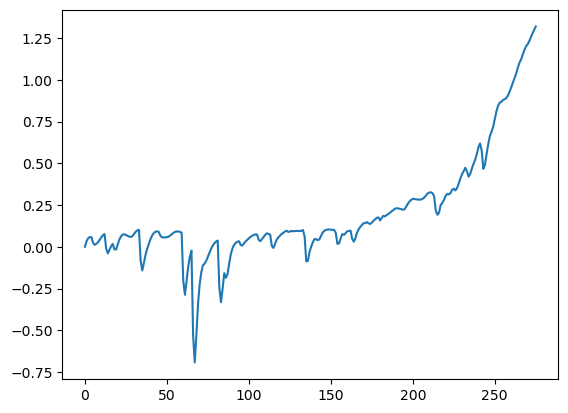

In [14]:
pl.plot(np.median(temp_out[:, 0, :], axis=1));

In [15]:
np.median(temp_out[:, 0, :], axis=1)

array([ 0.00000000e+00,  3.28371228e-02,  5.11537702e-02,  5.82016232e-02,
        5.72941781e-02,  2.34819136e-02,  1.12380051e-02,  1.81354134e-02,
        2.69311101e-02,  4.08931627e-02,  5.65959344e-02,  6.84881050e-02,
        7.60438526e-02, -1.25167183e-02, -3.98110969e-02, -1.68608551e-02,
        3.14065838e-03,  1.68191193e-02, -1.57688255e-02, -1.62095756e-02,
        1.36545845e-02,  4.24515975e-02,  6.19410385e-02,  7.26861743e-02,
        7.49715449e-02,  7.00119502e-02,  6.43687866e-02,  6.07887290e-02,
        5.87134648e-02,  6.32331555e-02,  7.67622581e-02,  8.99517087e-02,
        9.86352527e-02,  1.01393048e-01, -8.44062756e-02, -1.41816979e-01,
       -9.72767251e-02, -4.72208875e-02, -1.15270585e-02,  1.66052965e-02,
        4.54455008e-02,  6.71772639e-02,  8.14105779e-02,  8.94222645e-02,
        9.26610756e-02,  8.92411539e-02,  6.70153206e-02,  5.70612752e-02,
        5.58197728e-02,  5.59973085e-02,  5.74709171e-02,  6.04341906e-02,
        6.69914882e-02,  

In [ ]:
# os.makedirs('../output/results', exist_ok=True)

In [ ]:
ds = xr.Dataset(
    data_vars = dict(
        temperature_anomaly_rel_1750 = (['timebound', 'scenario', 'config'], temp_out),
        aerosol_forcing = (['timebound', 'scenario', 'config'], faer_out),
    ),
    coords = dict(
        timebound = np.arange(1750, 2102),
        scenario = labels,
        config = df_configs.index,
    ),
)
ds.to_netcdf('../output/results/scenariomip-cmip7.nc')